In [1]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import matplotlib.mlab as mlab
from scipy.io import wavfile
from matplotlib.pyplot import specgram
from scipy import signal
import scipy

In [3]:
def spectrum_density(data, sample_rate):
    
    # Periodogram analyse
    f, Pxx = scipy.signal.periodogram(data, sample_rate)
    fig, ax = plt.subplots(1, sharex=True, figsize=(10,4))
    plt.subplots_adjust(wspace =0.4, hspace =0)
    ax = plt.subplot(1,2,1)
    ax.semilogy(f, Pxx)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    ax.title.set_text('%s, Periodogram'%title)
    
    # Welsh analyse
    f, Pxx = scipy.signal.welch(data, sample_rate, nperseg=1024)
    print(f.shape)
    ax = plt.subplot(1,2,2)
    ax.semilogy(f, Pxx)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    

(513,)


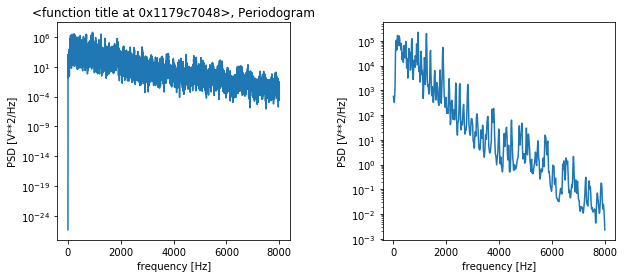

In [4]:
sample_rate, music = wavfile.read("music.wav")
spectrum_density(music, sample_rate)

## Simulate a noisy version of the music using the noises at various SNR Level

In [5]:
import pyroomacoustics as pra
from pyroomacoustics.denoise import SpectralSub

### For noise 1

In [6]:
noisy_signal15, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=5, noise_fp="noise1.wav")
noisy_signal130, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=30, noise_fp="noise1.wav")

* SNR = 5

(513,)


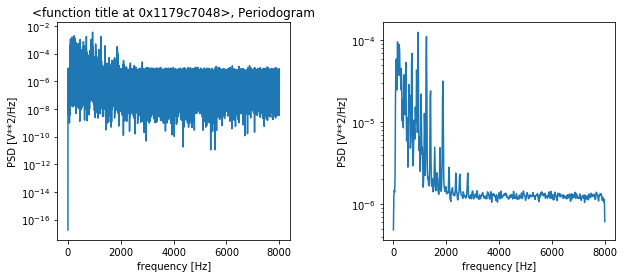

In [7]:
spectrum_density(noisy_signal15, fs)

* SNR = 30

(513,)


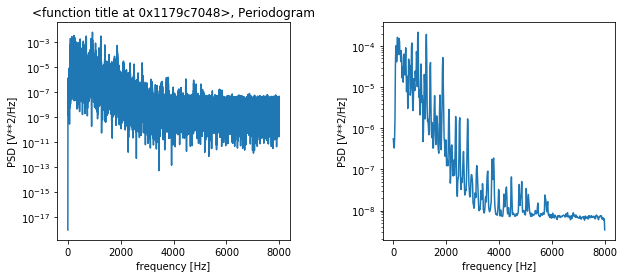

In [8]:
spectrum_density(noisy_signal130, fs)

### For noise 2

In [10]:
noisy_signal25, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=5, noise_fp="noise2.wav")
noisy_signal230, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=30, noise_fp="noise2.wav")

* SNR = 5

(513,)


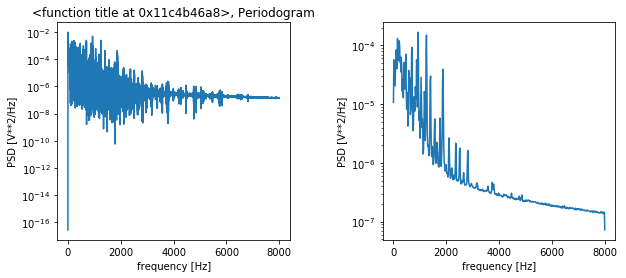

In [11]:
spectrum_density(noisy_signal25, fs)

* SNR = 30

(513,)


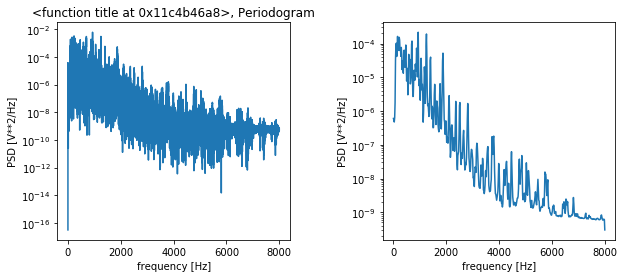

In [12]:
spectrum_density(noisy_signal230, fs)

### For noise 3

In [13]:
noisy_signal35, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=5, noise_fp="noise3.wav")
noisy_signal330, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=30, noise_fp="noise3.wav")

* SNR = 5

(513,)


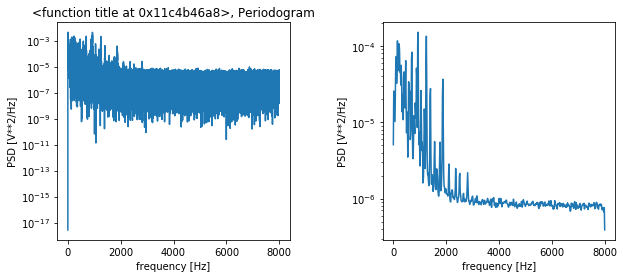

In [14]:
spectrum_density(noisy_signal35, fs)

* SNR = 30

(513,)


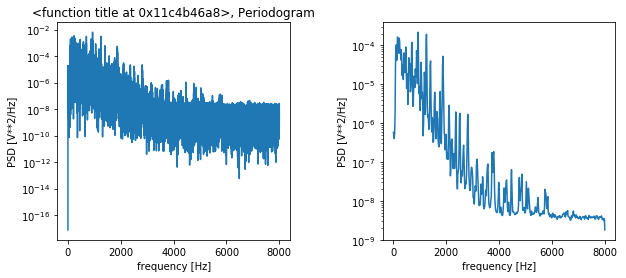

In [15]:
spectrum_density(noisy_signal330, fs)

## Implement the spectral substraction method for denoising 


In [16]:
def spectral_substraction(noisy_signal, signal, noise, fs):
    """
    Test and algorithm parameters
    """
    snr = 5         
    db_reduc = 10   
    nfft = 512  
    lookback = 1    
    beta = 3        
    alpha = 1.2 
    plot_spec = True
    
    """
    Create STFT and SCNR objects
    """
    hop = nfft // 2
    window = pra.hann(nfft, flag='asymmetric', length='full')
    stft = pra.transform.STFT(nfft, hop=hop, analysis_window=window, streaming=True)
    scnr = SpectralSub(nfft, db_reduc, lookback, beta, alpha)
    lookback_time = hop/fs * lookback    
    
    """
    Process as in real-time
    """
    # collect the processed blocks
    processed_audio = np.zeros(signal.shape)
    n = 0
    while noisy_signal.shape[0] - n >= hop:

        # SCNR in frequency domain
        stft.analysis(noisy_signal[n:(n+hop), ])
        gain_filt = scnr.compute_gain_filter(stft.X)

        # back to time domain
        processed_audio[n:n+hop, ] = stft.synthesis(gain_filt*stft.X)

        # update step
        n += hop  
    
    """
    Save and plot spectrogram
    """
    signal_norm = signal / np.abs(signal).max()
    
    if plot_spec:
        min_val = -80
        max_val = -40
        plt.figure()
        plt.subplot(3, 1, 1)
        plt.specgram(noisy_signal[:n-hop], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Noisy Signal')
        plt.subplot(3, 1, 2)
        plt.specgram(processed_audio[hop:n], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Denoised Signal')
        plt.subplot(3, 1, 3)
        plt.specgram(signal_norm[:n-hop], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Original Signal')
        plt.tight_layout(pad=0.5)
        plt.show()



## Denoise the different given noisy version of the clean signal

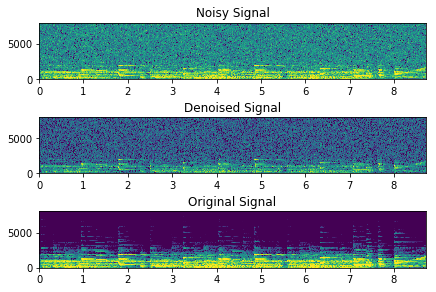

In [17]:
noisy_signal, signal, noise, fs = pra.create_noisy_signal("music.wav", snr=5, noise_fp="noise1.wav")
spectral_substraction(noisy_signal, signal, noise, fs)

## Discuss the parameters

In [18]:
# snr = 5         # SNR of input signal.
# db_reduc = 10   # Maximum suppression per frequency bin. Large suppresion can result in more musical noise.
# nfft = 512      # The size of the window. Frame length will be nfft/2 as we will use an STFT with 50% overlap.
# lookback = 1    # How many frames to look back for the noise floor estimate.
# beta = 3        # An overestimation factor to "push" the suppression towards db_reduc.
# alpha = 1.2     # An exponential factor to tune the suppresion.
# plot_spec = True